# 指数基金投资

基金投资是一种简单，较为无脑，门槛比较低的投资方式，很多10元就可以起投，方便构建投资组合。基金从大方面来讲，可以分为指数基金和主动管理型基金。
指数基金(Index Fund)，顾名思义就是追踪标的指数表现的基金产品。而主动管理型基金可以认为是让基金经理帮你炒股。从国外指数型基金迅速发展的历史来看，整体而言，大部分主动管理型基金并不比指数型基金更优秀。长期分析表明，大部分主动管理型基金都跑不过大盘。而指数增强基金则通过量化算法，可以在被动跟踪指数的基础上增加一个额外的收益，也是一种优秀的投资手段。
本部分主要基于现代投资组合理论，对中国基金市场上的指数和指数增强基金进行了简单分析，并尝试给出了一些投资组合建议。

导入使用到的包。投资组合优化和数据提取被封装到了 finvest 包中，导入后就可以使用

In [1]:
# 导入包
import pandas as pd
import datetime as dt
import sqlite3
import numpy as np
import math
from matplotlib import pyplot as plt
import traceback
import os
import sys
import numexpr as ne
import scipy.optimize as sco
import operator
%matplotlib inline

# 投资组合优化和数据提取被封装到了 finvest 包中，导入后就可以使用
nb_dir = os.path.split(os.getcwd())[0]
if not nb_dir in sys.path:
    sys.path.append(nb_dir)

from finvest.portfolio_opt import efficient_frontier
from finvest.funds_data import FundsData

通过字符串匹配寻找指数和指数增强基金

In [2]:
conn = sqlite3.connect('./data/fund-data.db')

df_funds = pd.DataFrame(conn.execute("select distinct code, name from fundValue where trade_date > '2017-01-01'")\
                        .fetchall(),columns=['code','name'])

index_funds = []
for i in range(len(df_funds)):
    code = df_funds['code'][i]
    name = df_funds['name'][i]
    if '指数' in name or '增强' in name:
        if not (name.endswith('A') or name.endswith('B') or name.endswith('C')): #只投资母基金
            if not '债' in name:
                index_funds.append((code,name))

sorted(index_funds,key=lambda a:a[1])

[(519180, '万家180指数'),
 (161910, '万家中创指数分级'),
 (161907, '万家中证红利指数'),
 (370023, '上投中证消费指数'),
 (165806, '东吴深证100增强'),
 (1884, '中欧沪深300指数增强E'),
 (502030, '中海中证高铁产业指数分级'),
 (168204, '中融中证煤炭指数分级'),
 (168205, '中融中证银行指数分级'),
 (168203, '中融国证钢铁行业指数分级'),
 (590007, '中邮上证380增强'),
 (49, '中银标普全球资源等权重指数'),
 (163821, '中银沪深300等权重指数'),
 (164907, '交银中证互联网金融指数分级'),
 (164905, '交银国证新能源指数分级'),
 (165519, '信诚中证800医药指数分级'),
 (165520, '信诚中证800有色指数分级'),
 (165521, '信诚中证800金融指数分级'),
 (165522, '信诚中证TMT产业指数分级'),
 (165523, '信诚中证信息安全指数分级'),
 (165525, '信诚中证基建工程指数LOF'),
 (165524, '信诚中证智能家居指数分级'),
 (163407, '兴全沪深300指数(LOF)'),
 (660014, '农银深证100增强'),
 (1027, '前海开源中证大农业指数增强'),
 (656, '前海开源沪深300指数'),
 (501050, '华夏上证50AH优选指数'),
 (40002, '华安中国A股增强指数'),
 (160419, '华安中证全指证券公司指数分级'),
 (160418, '华安中证银行指数分级'),
 (160420, '华安创业板50指数分级'),
 (160417, '华安沪深300指数分级'),
 (162413, '华宝兴业中证1000指数分级'),
 (162412, '华宝兴业中证医疗指数分级'),
 (501029, '华宝标普中国A股红利机会指数'),
 (162411, '华宝标普石油指数'),
 (3876, '华宝沪深300增强'),
 (410010, '华富中小板指数增强'),
 (835, '华润元大富时中国A50指

基金数量

In [3]:
len(index_funds)

160

导入数据，从2017年1月1日到6月1日，共半年时间

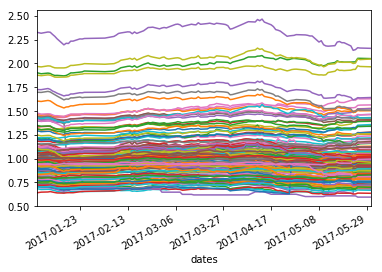

In [4]:
df = FundsData(dt.datetime(2017,1,1),dt.datetime(2017,6,1)).get_df(list(map(lambda a:a[0],index_funds)))
df.plot(legend=None)

计算每日收益

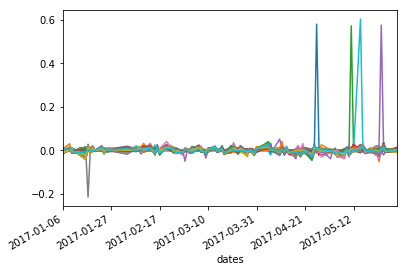

In [5]:
df_returns = df.pct_change().dropna()
df_returns.plot(legend=None)

可以看到其中有异常值，一般异常值由基金拆分、分红等情况引起，在这里可以简单将当天收益设为0来进行平滑

In [6]:
anomalies = np.where((np.abs(df_returns.values) > 0.1).any(axis=0))[0]
anomalies

array([ 27,  42,  49,  54, 100])

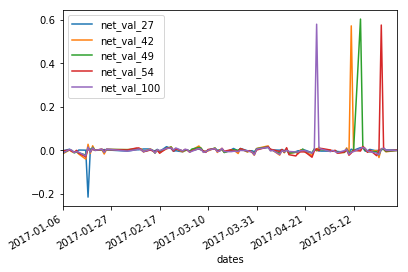

In [7]:
df_returns[anomalies].plot()

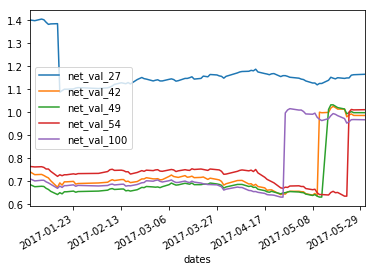

In [8]:
df[anomalies].plot()

In [9]:
operator.itemgetter(*anomalies)(index_funds)

((100032, '富国中证红利指数增强'),
 (160420, '华安创业板50指数分级'),
 (161025, '富国中证移动互联网指数分级'),
 (161030, '富国中证体育产业指数分级'),
 (164818, '工银中证传媒指数分级'))

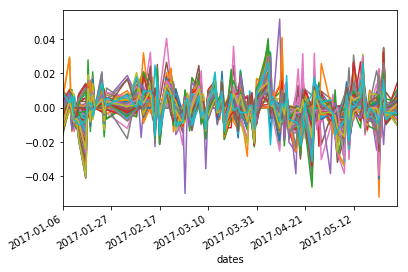

In [10]:
df_returns.values[np.abs(df_returns.values) > 0.1] = 0

df_returns.plot(legend=None)

写一个函数来计算特定投资比例下的平均收益和风险（标准差）

In [11]:
def portfolio(returns, weights):
    ''' 
    Returns the mean and standard deviation of returns for a portfolio
    '''
    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(weights)
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    return mu, sigma

在图中表示各个基金的收益与风险

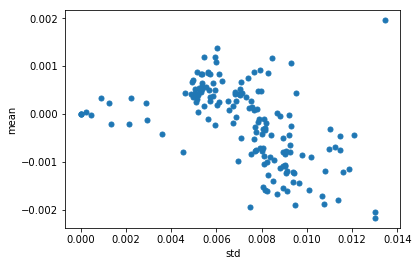

In [12]:
ms = []
for i in range(df_returns.shape[1]):
    weights = np.zeros(df_returns.shape[1])
    weights[i] = 1
    ms.append(portfolio(df_returns.values.T,weights))
means, stds = np.column_stack(ms)

plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')

计算投资的效率前沿

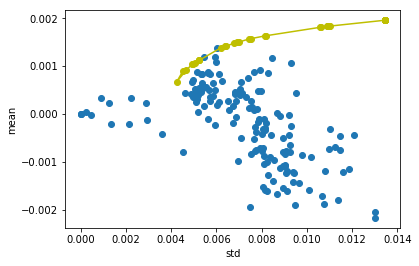

In [13]:
rets,risks,weights = efficient_frontier(df_returns.values.T)

plt.plot(stds, means, 'o')
plt.plot(risks, rets, 'y-o')
plt.xlabel('std')
plt.ylabel('mean')

生成投资组合，并查看效果

先计算效率前沿上的最高点，即收益最高的点

In [39]:
print('年化收益率\t风险\t夏普比率')
print('=======================================')
print('%.2f%%\t\t%.4f\t%.4f' % (rets[-1] * 240 * 100, risks[-1], rets[-1] / risks[-1] * np.sqrt(240)))
print('\n')

print('基金代号\t名称\t\t\t\t投资比例')
print('================================================')

funds_id = np.where(weights[-1] > 0.0001)[0]
if len(funds_id) == 1:
    fund = operator.itemgetter(*funds_id)(index_funds)
    print('%06d\t%-22s\t%.4f' % (fund[0],fund[1],weights[-1][weights[-1] > 0.0001][0]))
else:
    for line in zip(list(operator.itemgetter(*funds_id)(index_funds)),
                    list(weights[-1][weights[-1] > 0.0001])):
        print('%06d\t%-22s\t%.4f' % (line[0][0],line[0][1],line[1]))

年化收益率	风险	夏普比率
46.98%		0.0134	2.2560


基金代号	名称				投资比例
161725	招商中证白酒指数分级            	1.0000


再计算效率前沿上的最左点，即风险最低的点

In [37]:
print('年化收益率\t风险\t夏普比率')
print('=======================================')
print('%.2f%%\t\t%.4f\t%.4f' % (rets[0] * 240 * 100, risks[0], rets[0] / risks[0] * np.sqrt(240)))
print('\n')

print('基金代号\t名称\t\t\t\t投资比例')
print('================================================')

funds_id = np.where(weights[0] > 0.0001)[0]
if len(funds_id) == 1:
    fund = operator.itemgetter(*funds_id)(index_funds)
    print('%06d\t%-22s\t%.4f' % (fund[0],fund[1],weights[-1][weights[-1] > 0.0001][0]))
else:
    for line in zip(list(operator.itemgetter(*funds_id)(index_funds)),
                    list(weights[0][weights[0] > 0.0001])):
        print('%06d\t%-22s\t%.4f' % (line[0][0],line[0][1],line[1]))

年化收益率	风险	夏普比率
21.37%		0.0045	3.0570


基金代号	名称				投资比例
000176	嘉实沪深300指数研究增强         	0.0136
000311	景顺长城沪深300增强           	0.0220
000368	汇添富沪深300安中指数          	0.0107
000613	国寿安保沪深300指数           	0.0028
000835	华润元大富时中国A50指数         	0.0290
000961	天弘沪深300指数             	0.0003
001757	嘉实主题增强混合              	0.0190
001758	嘉实研究增强混合              	0.0191
001884	中欧沪深300指数增强E          	0.0021
002221	嘉实价值增强混合              	0.0108
003475	新疆前海联合沪深300指数         	0.0047
003876	华宝沪深300增强             	0.0230
004100	鹏华安益增强混合              	0.0059
004945	长信中证500指数增强           	0.0038
090010	大成中证红利指数              	0.0250
100032	富国中证红利指数增强            	0.0161
110030	易方达沪深300量化增强          	0.0090
160222	国泰国证食品饮料行业指数分级        	0.0291
160417	华安沪深300指数分级           	0.0053
160418	华安中证银行指数分级            	0.0093
160517	博时中证银行指数分级            	0.0208
160922	大成恒生综合中小型股指数          	0.0072
160924	大成恒生指数                	0.0038
161029	富国中证银行指数分级            	0.0045
161124	易方达香港恒生综合小型股指数        	0.0101
161213	国投瑞银消费服务指数    

在有效前沿上寻找夏普比率最大的点

In [16]:
# 拟合二次曲线，在其上找夏普比率最大的点
z = np.polyfit(rets,risks,2)
p = np.poly1d(z)
opt_rst = sco.minimize(lambda x:x[1] / x[0],np.array([rets[0],risks[0]]),bounds=[(0,0.3),(0,0.3)],
             constraints={'type':'eq','fun':lambda x:x[1] - p(x[0])})

# 根据找到的点，寻找对应的投资组合
def optimize_portfolio(returns,target_return):
    n = returns.shape[1]
    noa = returns.shape[0]
    
    Sigma = np.cov(returns)
    RT = np.mean(returns,axis=1)

    def variance(weights):
        wT = weights.flatten()
        w = wT.T
        risk = wT.dot(Sigma).dot(w)
        return risk

    def day_returns(weights):
        wT = weights.flatten()
        w = wT.T
        ret = RT.dot(w)
        return ret
    
    bnds = tuple((0,1) for x in range(noa))
    cons = ({'type':'eq','fun':lambda x:day_returns(x)-target_return},{'type':'eq','fun':lambda x:np.sum(x)-1})
    res = sco.minimize(variance, noa*[1./noa,],method = 'SLSQP', bounds = bnds, constraints = cons)
    
    target_risk = math.sqrt(res['fun'])

    return res.x,target_risk
w, r = optimize_portfolio(df_returns.values.T, opt_rst.x[0])

In [38]:
print('年化收益率\t风险\t夏普比率')
print('=======================================')
print('%.2f%%\t\t%.4f\t%.4f' % (opt_rst.x[0] * 240 * 100, r, opt_rst.x[0] / r * np.sqrt(240)))
print('\n')
print('基金代号\t名称\t\t\t\t投资比例')
print('================================================')

funds_id = np.where(w > 0.0001)[0]
if len(funds_id) == 1:
    fund = operator.itemgetter(*funds_id)(index_funds)
    print('%06d\t%-22s\t%.4f' % (fund[0],fund[1],weights[-1][weights[-1] > 0.0001][0]))
else:
    for line in zip(list(operator.itemgetter(*funds_id)(index_funds)),
                    list(w[w > 0.0001])):
        print('%06d\t%-22s\t%.4f' % (line[0][0],line[0][1],line[1]))

年化收益率	风险	夏普比率
28.80%		0.0056	3.2951


基金代号	名称				投资比例
000176	嘉实沪深300指数研究增强         	0.0045
000311	景顺长城沪深300增强           	0.0296
000835	华润元大富时中国A50指数         	0.0330
001758	嘉实研究增强混合              	0.0166
003876	华宝沪深300增强             	0.0279
090010	大成中证红利指数              	0.0321
100032	富国中证红利指数增强            	0.0042
160222	国泰国证食品饮料行业指数分级        	0.0601
160517	博时中证银行指数分级            	0.0054
161725	招商中证白酒指数分级            	0.1790
161831	银华恒生国企指数分级            	0.0310
162213	泰达宏利大盘指数              	0.0333
163407	兴全沪深300指数(LOF)        	0.0274
164508	国富中证100指数增强分级         	0.0117
164705	汇添富恒生指数分级             	0.1014
165519	信诚中证800医药指数分级         	0.0089
167301	方正富邦保险主题指数分级          	0.0741
213010	宝盈中证100增强             	0.0295
217027	招商央视财经50指数            	0.0607
310398	申万菱信沪深300价值指数         	0.0751
501023	鹏华香港中小企业指数LOF         	0.0349
501025	鹏华香港银行指数(LOF)         	0.0383
519116	浦银沪深300增强             	0.0056
519931	长信港股通指数               	0.0756
